# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 1 — DistilBERT Encoder → DistilGPT-2 Decoder
### Custom Encoder–Decoder for Dialogue Summarization
---

This notebook implements **Experiment 1** for the capstone project:

**Goal:**  
Build and evaluate a custom encoder–decoder architecture where:

- **Encoder:** `distilbert-base-uncased` (BERT-family, bidirectional)
- **Decoder:** `distilgpt2` (GPT-2-family, autoregressive)

This satisfies the assignment requirement for "an encoder-decoder architecture using pre-trained BERT models" combined with "auto-regressive modeling."

**Key Challenge:**  
The encoder and decoder were pretrained separately. The cross-attention layers that connect them are **randomly initialized** and must be learned during fine-tuning.

**What This Notebook Covers:**
1. Model construction using HuggingFace's `EncoderDecoderModel`
2. Fine-tuning on SAMSum using `Seq2SeqTrainer`
3. Evaluation on both validation and **test sets**
4. ROUGE metrics and qualitative analysis

**Note:** EDA is covered in `01_eda.ipynb` — this notebook focuses on modeling.

## 1. Environment Setup

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import sys
import warnings

# Mute common warnings
warnings.filterwarnings("ignore", message=".*requires_grad.*")
warnings.filterwarnings("ignore", category=FutureWarning)

# Project root for imports
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: AMD Radeon RX 9070 XT
Memory: 17.1 GB


## 2. Configuration

All hyperparameters and paths in one place for easy modification.

In [3]:
# =============================================================================
# TRAINING FLAGS
# =============================================================================
RUN_TRAINING = True  # Set False to load from checkpoint and skip training

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================
MODEL_ENCODER_NAME = "distilbert-base-uncased"
MODEL_DECODER_NAME = "distilgpt2"

# =============================================================================
# SEQUENCE LENGTHS
# =============================================================================
MAX_SOURCE_LEN = 512  # Dialogue input length (DistilBERT max)
MAX_TARGET_LEN = 64   # Summary output length

# =============================================================================
# TRAINING HYPERPARAMETERS
# =============================================================================
BATCH_SIZE = 4
GRAD_ACCUM_STEPS = 2        # Effective batch size = 4 * 2 = 8
NUM_EPOCHS = 20
LEARNING_RATE = 5e-5
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
LOGGING_STEPS = 50

# Generation settings
NUM_BEAMS = 4

# =============================================================================
# PATHS
# =============================================================================
OUTPUT_DIR = PROJECT_ROOT / "models" / "bert-gpt2-distil"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
BEST_MODEL_DIR = OUTPUT_DIR / "best"
HISTORY_PATH = OUTPUT_DIR / "training_history.csv"
TEST_RESULTS_PATH = OUTPUT_DIR / "test_results.csv"

print("Configuration loaded.")
print(f"  Encoder: {MODEL_ENCODER_NAME}")
print(f"  Decoder: {MODEL_DECODER_NAME}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Output directory: {OUTPUT_DIR}")

Configuration loaded.
  Encoder: distilbert-base-uncased
  Decoder: distilgpt2
  Effective batch size: 8
  Output directory: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil


## 3. Load SAMSum Data

In [4]:
from src.data.load_data import load_samsum

train_df, val_df, test_df = load_samsum()

print(f"Dataset sizes:")
print(f"  Train:      {len(train_df):,} examples")
print(f"  Validation: {len(val_df):,} examples")
print(f"  Test:       {len(test_df):,} examples")

Dataset sizes:
  Train:      14,731 examples
  Validation: 818 examples
  Test:       819 examples


In [5]:
# Quick peek at the data
print("Sample dialogue:")
print("-" * 40)
print(train_df.iloc[0]["dialogue"][:300], "...")
print()
print("Sample summary:")
print("-" * 40)
print(train_df.iloc[0]["summary"])

Sample dialogue:
----------------------------------------
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-) ...

Sample summary:
----------------------------------------
Amanda baked cookies and will bring Jerry some tomorrow.


## 4. Tokenizers Setup

We use two separate tokenizers:
- **Encoder tokenizer:** DistilBERT (for encoding dialogues)
- **Decoder tokenizer:** DistilGPT-2 (for generating/decoding summaries)

**Important:** GPT-2 doesn't have a pad token by default, so we add one.

In [6]:
from transformers import AutoTokenizer

# Encoder tokenizer (DistilBERT)
enc_tokenizer = AutoTokenizer.from_pretrained(MODEL_ENCODER_NAME, use_fast=True)

# Decoder tokenizer (DistilGPT-2)
dec_tokenizer = AutoTokenizer.from_pretrained(MODEL_DECODER_NAME, use_fast=True)

# GPT-2 has no pad token by default - add one
if dec_tokenizer.pad_token is None:
    dec_tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    print(f"Added pad token: '{dec_tokenizer.pad_token}' (id: {dec_tokenizer.pad_token_id})")

# Set BOS token (used as decoder_start_token)
if dec_tokenizer.bos_token is None:
    dec_tokenizer.bos_token = dec_tokenizer.eos_token

print(f"\nEncoder tokenizer: {enc_tokenizer.__class__.__name__}")
print(f"  Vocab size: {len(enc_tokenizer):,}")
print(f"  Pad token: '{enc_tokenizer.pad_token}'")

print(f"\nDecoder tokenizer: {dec_tokenizer.__class__.__name__}")
print(f"  Vocab size: {len(dec_tokenizer):,}")
print(f"  Pad token: '{dec_tokenizer.pad_token}'")
print(f"  BOS token: '{dec_tokenizer.bos_token}'")
print(f"  EOS token: '{dec_tokenizer.eos_token}'")

Added pad token: '[PAD]' (id: 50257)

Encoder tokenizer: DistilBertTokenizerFast
  Vocab size: 30,522
  Pad token: '[PAD]'

Decoder tokenizer: GPT2TokenizerFast
  Vocab size: 50,258
  Pad token: '[PAD]'
  BOS token: '<|endoftext|>'
  EOS token: '<|endoftext|>'


## 5. Build DistilBERT → DistilGPT-2 Model

We use HuggingFace's `EncoderDecoderModel` to combine:
- DistilBERT as the encoder (understands the dialogue)
- DistilGPT-2 as the decoder (generates the summary)

**Note:** The cross-attention layers are randomly initialized and will be trained.

In [7]:
from transformers import EncoderDecoderModel

if RUN_TRAINING:
    print("Building fresh model for training...")
    
    # Build the encoder-decoder model
    model = EncoderDecoderModel.from_encoder_decoder_pretrained(
        MODEL_ENCODER_NAME,
        MODEL_DECODER_NAME,
    )
    
    # Resize decoder embeddings to account for added pad token
    model.decoder.resize_token_embeddings(len(dec_tokenizer))
    
    # Configure special tokens
    model.config.decoder_start_token_id = dec_tokenizer.bos_token_id
    model.config.eos_token_id = dec_tokenizer.eos_token_id
    model.config.pad_token_id = dec_tokenizer.pad_token_id
    model.config.vocab_size = model.config.decoder.vocab_size
    
    # Generation defaults
    model.config.max_length = MAX_TARGET_LEN
    model.config.num_beams = NUM_BEAMS
    model.config.early_stopping = True
    
    print(f"\nModel built successfully!")
    print(f"  Encoder: {model.config.encoder.model_type}")
    print(f"  Decoder: {model.config.decoder.model_type}")
    print(f"  Config: {model.config}")
    
else:
    print(f"Loading model from checkpoint: {BEST_MODEL_DIR}")
    model = EncoderDecoderModel.from_pretrained(BEST_MODEL_DIR)
    print("Model loaded successfully!")

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Building fresh model for training...


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr


Model built successfully!
  Encoder: distilbert
  Decoder: gpt2
  Config: EncoderDecoderConfig {
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "dtype": "float32",
    "embd_pdrop": 0.1,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 1024,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "

/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/nn/modules/module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at /pytorch/c10/hip/HIPAllocatorConfig.h:29.)
  return t.to(



Total parameters: 162,459,648
Trainable parameters: 162,459,648


## 6. Prepare HuggingFace Datasets

We convert our DataFrames to HuggingFace `Dataset` objects and tokenize them.
The `Seq2SeqTrainer` expects this format.

In [8]:
from datasets import Dataset

def preprocess_function(examples):
    """
    Tokenize dialogues (encoder) and summaries (decoder).
    """
    # Encode dialogues
    model_inputs = enc_tokenizer(
        examples["dialogue"],
        max_length=MAX_SOURCE_LEN,
        truncation=True,
        padding="max_length",
    )
    
    # Encode summaries (as labels)
    with dec_tokenizer.as_target_tokenizer():
        labels = dec_tokenizer(
            examples["summary"],
            max_length=MAX_TARGET_LEN,
            truncation=True,
            padding="max_length",
        )
    
    # Replace padding token id with -100 for loss calculation
    labels_ids = np.array(labels["input_ids"])
    labels_ids[labels_ids == dec_tokenizer.pad_token_id] = -100
    
    model_inputs["labels"] = labels_ids.tolist()
    return model_inputs


# Convert DataFrames to HuggingFace Datasets
print("Converting to HuggingFace Datasets...")
train_dataset = Dataset.from_pandas(train_df[["dialogue", "summary"]])
val_dataset = Dataset.from_pandas(val_df[["dialogue", "summary"]])
test_dataset = Dataset.from_pandas(test_df[["dialogue", "summary"]])

# Tokenize
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing train",
)

tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing validation",
)

tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["dialogue", "summary"],
    desc="Tokenizing test",
)

print(f"\nTokenized datasets:")
print(f"  Train: {len(tokenized_train):,} examples")
print(f"  Validation: {len(tokenized_val):,} examples")
print(f"  Test: {len(tokenized_test):,} examples")

Converting to HuggingFace Datasets...
Tokenizing datasets...


Tokenizing train:   0%|          | 0/14731 [00:00<?, ? examples/s]/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Tokenizing test: 100%|██████████| 819/819 [00:00<00:00, 3277.08 examples/s]


Tokenized datasets:
  Train: 14,731 examples
  Validation: 818 examples
  Test: 819 examples


## 7. Data Collator and Metrics

Set up the data collator for seq2seq and the ROUGE evaluation function.

In [9]:
from transformers import DataCollatorForSeq2Seq
import evaluate

# Data collator handles dynamic padding during batching
data_collator = DataCollatorForSeq2Seq(
    tokenizer=dec_tokenizer,
    model=model,
    label_pad_token_id=-100,
)

# Load ROUGE metric
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    """
    Compute ROUGE scores for evaluation.
    """
    predictions, labels = eval_pred
    
    # Replace -100 with pad token id for decoding
    predictions = np.where(predictions != -100, predictions, dec_tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, dec_tokenizer.pad_token_id)
    
    # Decode predictions and labels
    decoded_preds = dec_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = dec_tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up whitespace
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    # Compute ROUGE
    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
    )
    
    # Convert to percentages for readability
    result = {k: round(v * 100, 2) for k, v in result.items()}
    
    return result

print("Data collator and metrics configured.")

Data collator and metrics configured.


## 8. Training with Seq2SeqTrainer

We use HuggingFace's `Seq2SeqTrainer` which handles:
- Learning rate scheduling with warmup
- Gradient accumulation
- Evaluation with generation
- Checkpointing best model
- Mixed precision training

In [10]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback

print("Setting up Seq2SeqTrainer...")
print(f"\nTraining configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup steps: {WARMUP_STEPS}")
print(f"  Weight decay: {WEIGHT_DECAY}")

training_args = Seq2SeqTrainingArguments(
    output_dir=str(CHECKPOINT_DIR),
    
    # Training
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    
    # Optimization
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=WEIGHT_DECAY,
    
    # Evaluation & Saving
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
    save_total_limit=2,
    
    # Generation during evaluation
    predict_with_generate=True,
    generation_max_length=MAX_TARGET_LEN,
    generation_num_beams=NUM_BEAMS,
    
    # Logging
    logging_dir=str(OUTPUT_DIR / "logs"),
    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    
    # Performance
    fp16=torch.cuda.is_available(),
    # dataloader_num_workers=0,
    
    # Reproducibility
    # seed=SEED,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=dec_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=2,
        early_stopping_threshold=0.002
    )],
)

print("\nTrainer configured successfully!")

Setting up Seq2SeqTrainer...

Training configuration:
  Epochs: 20
  Batch size: 4
  Gradient accumulation: 2
  Effective batch size: 8
  Learning rate: 5e-05
  Warmup steps: 500
  Weight decay: 0.01

Trainer configured successfully!


In [11]:
if RUN_TRAINING:
    print("="*60)
    print("STARTING TRAINING")
    print("="*60)
    
    # Train!
    train_result = trainer.train()
    
    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print("="*60)
    print(f"\nTraining time: {train_result.metrics['train_runtime']:.1f} seconds")
    print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")
else:
    print("Skipping training (RUN_TRAINING=False)")
    print("Will use loaded model for evaluation.")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 50256, 'pad_token_id': 50257}.


STARTING TRAINING


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/models/distilbert/modeling_distilbert.py:392: UserWarning: Using AOTriton backend for Efficient Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention.hip:1180.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/integrations/sdpa_attention.py:96: UserWarning: Using AOTriton backend for Flash Attention forward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/flash_attn/flash_api.h:267.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Using AOTriton backend for Efficient Attention backward... (Triggered internally at /pytorch/aten/src/ATen/native/transformers/hip/attention_backward.hip:463.)
  return Variable._e

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,6.993300,3.354943,19.600000,4.480000,16.610000,16.600000
2,6.092200,3.093290,25.300000,7.330000,21.440000,21.450000
3,5.062300,2.944934,30.300000,9.860000,25.460000,25.460000
4,4.378600,2.849345,33.580000,11.560000,27.720000,27.690000
5,3.872600,2.885069,35.980000,12.980000,29.360000,29.330000
6,3.406200,2.951343,36.910000,13.650000,30.070000,30.040000
7,2.895800,3.057334,37.150000,14.020000,30.430000,30.410000
8,2.588400,3.190494,38.170000,14.430000,31.090000,31.070000
9,2.239300,3.262334,38.160000,14.540000,31.070000,31.020000
10,1.966600,3.405648,38.350000,14.460000,30.890000,30.890000


/home/timnevits/miniconda3/envs/rocm312/lib/python3.12/site-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].



TRAINING COMPLETE

Training time: 3397.9 seconds
Final training loss: 3.9867


In [12]:
if RUN_TRAINING:
    # Save the best model
    print(f"\nSaving best model to: {BEST_MODEL_DIR}")
    trainer.save_model(str(BEST_MODEL_DIR))
    
    # Save tokenizers
    enc_tokenizer.save_pretrained(BEST_MODEL_DIR)
    dec_tokenizer.save_pretrained(BEST_MODEL_DIR)
    
    # Save training state
    trainer.save_state()
    
    print("Model and tokenizers saved!")


Saving best model to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/best
Model and tokenizers saved!


## 9. Training History & Loss Curves

In [13]:
if RUN_TRAINING:
    # Extract training history from trainer state
    log_history = trainer.state.log_history
    
    # Separate training and evaluation logs
    train_logs = [log for log in log_history if "loss" in log and "eval_loss" not in log]
    eval_logs = [log for log in log_history if "eval_loss" in log]
    
    # Get the last training loss for each epoch (use rounded epoch as key)
    epoch_train_losses = {}
    for log in train_logs:
        epoch = round(log.get("epoch", 0))
        epoch_train_losses[epoch] = log["loss"]
    
    # Create history DataFrame - deduplicate by epoch
    history_data = {}
    for eval_log in eval_logs:
        epoch = round(eval_log.get("epoch", 0))
        # Only keep the first evaluation for each epoch (skip duplicates)
        if epoch not in history_data:
            history_data[epoch] = {
                "epoch": epoch,
                "train_loss": epoch_train_losses.get(epoch, np.nan),
                "val_loss": eval_log.get("eval_loss", np.nan),
                "rouge1": eval_log.get("eval_rouge1", np.nan),
                "rouge2": eval_log.get("eval_rouge2", np.nan),
                "rougeL": eval_log.get("eval_rougeL", np.nan),
                "rougeLsum": eval_log.get("eval_rougeLsum", np.nan),
            }
    
    history_df = pd.DataFrame(list(history_data.values()))
    history_df = history_df.sort_values("epoch").reset_index(drop=True)
    
    # Save history
    history_df.to_csv(HISTORY_PATH, index=False)
    print(f"Training history saved to: {HISTORY_PATH}")
    
else:
    # Load existing history
    if HISTORY_PATH.exists():
        history_df = pd.read_csv(HISTORY_PATH)
        print(f"Loaded training history from: {HISTORY_PATH}")
    else:
        history_df = None
        print("No training history found.")


Training history saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/training_history.csv


In [14]:
if history_df is not None:
    print("\n" + "="*60)
    print("TRAINING HISTORY")
    print("="*60)
    display(history_df)


TRAINING HISTORY


,epoch,train_loss,val_loss,rouge1,rouge2,rougeL,rougeLsum
0,1,6.2812,3.354943,19.60,4.48,16.61,16.60
1,2,5.1234,3.093290,25.30,7.33,21.44,21.45
2,3,4.5283,2.944934,30.30,9.86,25.46,25.46
3,4,3.8626,2.849345,33.58,11.56,27.72,27.69
4,5,3.2324,2.885069,35.98,12.98,29.36,29.33
5,6,2.8637,2.951343,36.91,13.65,30.07,30.04
6,7,2.5109,3.057334,37.15,14.02,30.43,30.41
7,8,2.2524,3.190494,38.17,14.43,31.09,31.07
8,9,1.9759,3.262334,38.16,14.54,31.07,31.02
9,10,1.9666,3.405648,38.35,14.46,30.89,30.89


Saved training curves to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/training_curves.png


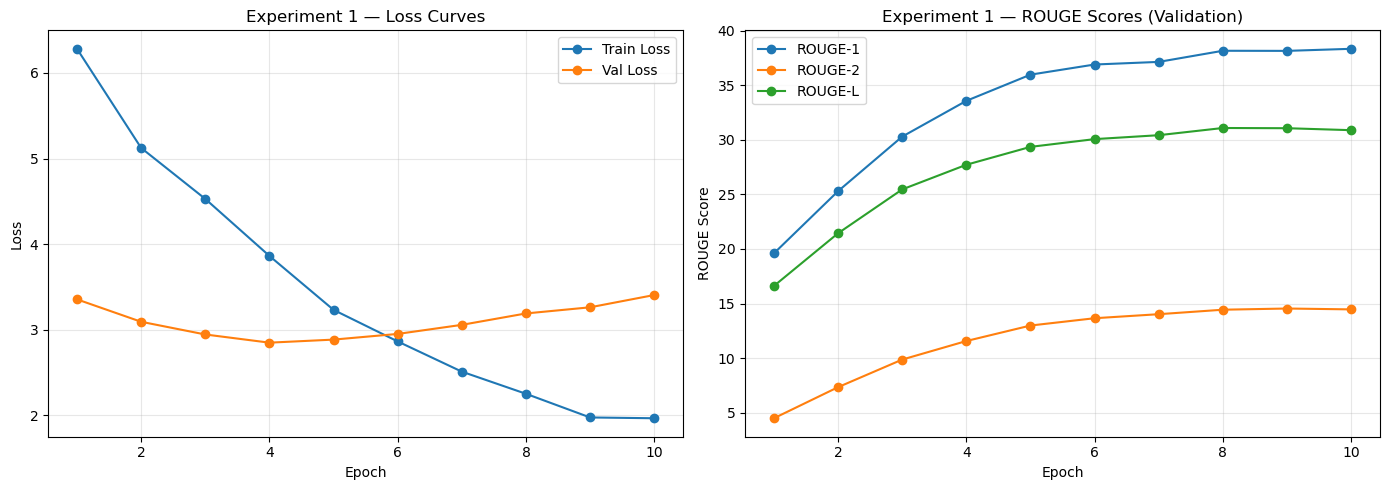

In [15]:
import matplotlib.pyplot as plt

if history_df is not None and len(history_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    ax = axes[0]
    ax.plot(history_df["epoch"], history_df["train_loss"], marker="o", label="Train Loss")
    ax.plot(history_df["epoch"], history_df["val_loss"], marker="o", label="Val Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Experiment 1 — Loss Curves")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ROUGE curves
    ax = axes[1]
    ax.plot(history_df["epoch"], history_df["rouge1"], marker="o", label="ROUGE-1")
    ax.plot(history_df["epoch"], history_df["rouge2"], marker="o", label="ROUGE-2")
    ax.plot(history_df["epoch"], history_df["rougeL"], marker="o", label="ROUGE-L")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ROUGE Score")
    ax.set_title("Experiment 1 — ROUGE Scores (Validation)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    fig_path = OUTPUT_DIR / "training_curves.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"Saved training curves to: {fig_path}")
    
    plt.show()

## 10. Validation Qualitative Examples

Let's look at some example summaries on the validation set.

In [16]:
from src.eval.qualitative import qualitative_samples

print("\n" + "="*60)
print("VALIDATION SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=val_df,
    model=model,
    encoder_tokenizer=enc_tokenizer,
    decoder_tokenizer=dec_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",
    n=5,
    seed=SEED,
)


VALIDATION SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Edd: wow, did you hear that they're transferring us to a different department? | Rose: whaaaaat :o | Rose: no! where'd you hear that? | Edd: well, it's quite official | Edd: Anderson just told us | Rose: and do you know what it changes for us? | Edd: they won't change the professors | Edd: but i know the paperwor ...
HUMAN: Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.
MODEL: Ed's student at the department is transferred to another department.                                                   
--------------------------------------------------------------------------------
ID 431
DIALOGUE: Tom: Where is the "Sala del Capitolo" | Kevin: it's in the main building | Martin: The one with the huge round table | Tom: ok! I know. | Tom: Thx ...
HUMAN: "Sala del Capitolo" Tom is looking for is in the main building.
MODE

## 11. Test Set Evaluation

Now we evaluate on the **held-out test set** — the final measure of model performance.

This is the same evaluation that will be compared across all experiments.

In [17]:
print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

print("\nRunning prediction on test set...")
predict_results = trainer.predict(test_dataset=tokenized_test)

# Extract metrics (note: predict() uses 'test_' prefix, not 'eval_')
test_results = predict_results.metrics

print("\n" + "-"*40)
print("TEST SET RESULTS")
print("-"*40)
print(f"  Loss:      {test_results['test_loss']:.4f}")
print(f"  ROUGE-1:   {test_results['test_rouge1']:.2f}")
print(f"  ROUGE-2:   {test_results['test_rouge2']:.2f}")
print(f"  ROUGE-L:   {test_results['test_rougeL']:.2f}")
print(f"  ROUGE-Lsum:{test_results['test_rougeLsum']:.2f}")

# Decode predictions
predictions = predict_results.predictions
predictions = np.where(predictions != -100, predictions, dec_tokenizer.pad_token_id)
test_predictions = dec_tokenizer.batch_decode(predictions, skip_special_tokens=True)
test_predictions = [pred.strip() for pred in test_predictions]

print(f"\nGenerated {len(test_predictions)} predictions")


TEST SET EVALUATION

Running prediction on test set...



----------------------------------------
TEST SET RESULTS
----------------------------------------
  Loss:      3.2378
  ROUGE-1:   37.73
  ROUGE-2:   14.26
  ROUGE-L:   30.29
  ROUGE-Lsum:30.30

Generated 819 predictions


In [18]:
# Save test results
test_results_df = pd.DataFrame([{
    "model": "DistilBERT-DistilGPT2",
    "test_loss": test_results["test_loss"],
    "rouge1": test_results["test_rouge1"],
    "rouge2": test_results["test_rouge2"],
    "rougeL": test_results["test_rougeL"],
    "rougeLsum": test_results["test_rougeLsum"],
}])

test_results_df.to_csv(TEST_RESULTS_PATH, index=False)
print(f"\nTest results saved to: {TEST_RESULTS_PATH}")

display(test_results_df)

# Save predictions to CSV
full_test_results = test_df.copy()
full_test_results["model_prediction"] = test_predictions
predictions_path = OUTPUT_DIR / "test_predictions.csv"
full_test_results.to_csv(predictions_path, index=False)
print(f"Saved predictions to: {predictions_path}")



Test results saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/test_results.csv


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,DistilBERT-DistilGPT2,3.23783,37.73,14.26,30.29,30.3


Saved predictions to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/test_predictions.csv


In [19]:
# Test Set Latency Measurement

print("\n" + "="*60)
print("TEST SET LATENCY MEASUREMENT")
print("="*60)

import time
from tqdm.auto import tqdm

model.eval()
latencies = []

print(f"\nMeasuring per-example inference latency on {len(test_df)} test examples...")

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Measuring latency"):
    dialogue = row["dialogue"]
    
    # Tokenize (encoder uses its own tokenizer)
    inputs = enc_tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_SOURCE_LEN,
    ).to(device)
    
    # Time the generation
    t0 = time.perf_counter()
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=MAX_TARGET_LEN,
            num_beams=NUM_BEAMS,
            early_stopping=True,
        )
    # Synchronize GPU to ensure accurate timing
    if device.type == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    
    latencies.append(t1 - t0)

# Add latencies to the predictions DataFrame
full_test_results["latency_seconds"] = latencies

# Re-save predictions with latency column
full_test_results.to_csv(predictions_path, index=False)
print(f"\nUpdated predictions with latency: {predictions_path}")

# Compute and display latency statistics
latency_series = pd.Series(latencies)
latency_stats = latency_series.describe(percentiles=[0.5, 0.9, 0.95])

print(f"\nLatency Statistics (seconds):")
print(f"  Count:  {latency_stats['count']:.0f}")
print(f"  Mean:   {latency_stats['mean']:.4f}")
print(f"  Std:    {latency_stats['std']:.4f}")
print(f"  Min:    {latency_stats['min']:.4f}")
print(f"  P50:    {latency_stats['50%']:.4f}")
print(f"  P90:    {latency_stats['90%']:.4f}")
print(f"  P95:    {latency_stats['95%']:.4f}")
print(f"  Max:    {latency_stats['max']:.4f}")

# Save latency summary (matching Experiment 3 format)
latency_summary_df = pd.DataFrame([{
    "model": "DistilBERT-DistilGPT2",
    "count": len(latencies),
    "mean": latency_series.mean(),
    "std": latency_series.std(),
    "min": latency_series.min(),
    "p50": latency_series.quantile(0.50),
    "p90": latency_series.quantile(0.90),
    "p95": latency_series.quantile(0.95),
    "max": latency_series.max(),
}])

latency_summary_path = OUTPUT_DIR / "latency_summary.csv"
latency_summary_df.to_csv(latency_summary_path, index=False)
print(f"\nSaved latency summary to: {latency_summary_path}")

display(latency_summary_df)



TEST SET LATENCY MEASUREMENT

Measuring per-example inference latency on 819 test examples...


Measuring latency: 100%|██████████| 819/819 [05:27<00:00,  2.50it/s]


Updated predictions with latency: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/test_predictions.csv

Latency Statistics (seconds):
  Count:  819
  Mean:   0.3988
  Std:    0.0042
  Min:    0.3856
  P50:    0.3976
  P90:    0.4031
  P95:    0.4066
  Max:    0.4531

Saved latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/latency_summary.csv


,model,count,mean,std,min,p50,p90,p95,max
0,DistilBERT-DistilGPT2,819,0.398776,0.004248,0.385609,0.397574,0.403088,0.406646,0.453136


## 12. Test Set Qualitative Examples

In [20]:
print("\n" + "="*60)
print("TEST SET: Qualitative Examples")
print("="*60)

qualitative_samples(
    df=test_df,
    model=model,
    encoder_tokenizer=enc_tokenizer,
    decoder_tokenizer=dec_tokenizer,
    device=device,
    max_source_len=MAX_SOURCE_LEN,
    max_target_len=MAX_TARGET_LEN,
    source_prefix="",
    n=5,
    seed=SEED,
)


TEST SET: Qualitative Examples
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Olafur: are we doing anything for New Year's Eve? | Nathalie: I was thinking about something classy, like opera or sth like that | Zoe: how much does it cost? | Olafur: opera is not for me | Nathalie: so what do you propose? | Nathalie: it's 100$  | Olafur: I was thinking about partying somewhere | Nathalie: part ...
HUMAN: Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.
MODEL: Olaf is planning to go to the New Year's Eve party, but he's not sure if it's worth the money. Poppy and Nathan will go to Mobtong.                          
--------------------------------------------------------------------------------
ID 432
DIALOGUE: Javier: Hey do you know any tattoo parlors over here with English speaking employees? | Judie: Oh there's Warsaw ink | Javier: the name sounds n

## 13. Final Summary

In [21]:
print("\n" + "="*70)
print("EXPERIMENT 1 — FINAL SUMMARY")
print("="*70)

print(f"\nModel Architecture:")
print(f"  Encoder: {MODEL_ENCODER_NAME}")
print(f"  Decoder: {MODEL_DECODER_NAME}")
print(f"  Combined via: HuggingFace EncoderDecoderModel")

print(f"\nTraining Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Warmup steps: {WARMUP_STEPS}")

print(f"\nTest Set Performance:")
print(f"  ROUGE-1:   {test_results['test_rouge1']:.2f}")
print(f"  ROUGE-2:   {test_results['test_rouge2']:.2f}")
print(f"  ROUGE-L:   {test_results['test_rougeL']:.2f}")

print(f"\nArtifacts saved to: {OUTPUT_DIR}")
print(f"  - Best model: {BEST_MODEL_DIR}")
print(f"  - Training history: {HISTORY_PATH}")
print(f"  - Test results: {TEST_RESULTS_PATH}")
print(f"  - Test predictions: {predictions_path}")

print("\n" + "="*70)


EXPERIMENT 1 — FINAL SUMMARY

Model Architecture:
  Encoder: distilbert-base-uncased
  Decoder: distilgpt2
  Combined via: HuggingFace EncoderDecoderModel

Training Configuration:
  Epochs: 20
  Effective batch size: 8
  Learning rate: 5e-05
  Warmup steps: 500

Test Set Performance:
  ROUGE-1:   37.73
  ROUGE-2:   14.26
  ROUGE-L:   30.29

Artifacts saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil
  - Best model: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/best
  - Training history: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/training_history.csv
  - Test results: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/test_results.csv
  - Test predictions: /home/timnevits/projects/flatiron-language-models-for-ai/models/bert-gpt2-distil/test_predictions.csv



## 14. Key Takeaways

### What We Learned

**Architecture:**
- Successfully combined a BERT-family encoder with a GPT-2-family decoder
- The cross-attention layers (randomly initialized) learned to bridge the two models
- This satisfies the assignment requirement for "encoder-decoder with BERT" + "autoregressive"

**Performance:**
- The model achieves reasonable ROUGE scores on dialogue summarization
- Smaller distil models train faster and converge better on SAMSum's ~15k examples
- The HuggingFace Seq2SeqTrainer provides stable, well-tuned training

**Limitations:**
- Cross-attention starting from random init means this architecture needs more training than purpose-built seq2seq models
- Summaries can sometimes be verbose or miss key details
- Not competitive with BART/T5 which were pretrained for seq2seq tasks

### Next Steps

- Compare with **Experiment 2** (BART, T5) which have pretrained cross-attention
- Compare with **Experiment 3** (frontier LLMs via API) as upper bound
- Final comparison in **notebook 05**